* **Student**: Minhchau Dang
* **Email Address**: minhchau.dang@berkeley.edu
* **Course**: 2016-0111 DATASCI W261: Machine Learning at Scale
* **Section**: Spring 2016, Section 2
* **Assignment**: Homework 7, Week 9
* **Submission Date**: March 10, 2016

This notebook requires some nbextensions.

* [ruler](https://github.com/ipython-contrib/IPython-notebook-extensions/tree/master/nbextensions/usability/ruler) highlights a maximum line number so that you can avoid writing code that exceeds that character count
* [toc2](https://github.com/ipython-contrib/IPython-notebook-extensions/tree/master/nbextensions/usability/toc2) provides a button to create a floating table of contents
* [toggle_all_line_numbers](https://github.com/ipython-contrib/IPython-notebook-extensions/tree/master/nbextensions/usability/toggle_all_line_numbers) provides a button to see line numbers for all code cells
* [autosaveclasses](https://github.com/holatuwol/jupyter-magic/tree/master/nbextensions/autosaveclasses.js) avoids usage of `%%writefile` (cells with a class definition are saved to disk when run)

If they are not yet installed, run the following cell and restart the notebook server.

In [1]:
%%bash
IPYTHON_PROFILE_HOME=$(ipython locate)
GITHUB_REPO=

nbextdl() {
    if [ ! -f $IPYTHON_PROFILE_HOME/nbextensions/$1/$2 ]; then
        mkdir -p $IPYTHON_PROFILE_HOME/nbextensions/$1
        curl --silent -L \
            "https://raw.githubusercontent.com/$GITHUB_REPO/master/nbextensions/$1/$2" \
            > "$IPYTHON_PROFILE_HOME/nbextensions/$1/$2"
    fi
}

GITHUB_REPO=ipython-contrib/IPython-notebook-extensions

nbextdl usability/ruler main.js
nbextdl usability/ruler icon.png

nbextdl usability/toc2 main.js
nbextdl usability/toc2 main.css
nbextdl usability/toc2 icon.png
nbextdl usability/toc2 image.png

nbextdl usability/toggle_all_line_numbers main.js
nbextdl usability/toggle_all_line_numbers icon.png

GITHUB_REPO=holatuwol/jupyter-magic

nbextdl . autosaveclasses.js

Load the extensions.

In [2]:
%%javascript
require(['base/js/utils'], function(utils) {
    utils.load_extensions('usability/toc2/main');
    utils.load_extensions('usability/ruler/main');
    utils.load_extensions('usability/toggle_all_line_numbers/main');
    utils.load_extensions('autosaveclasses');
});

<IPython.core.display.Javascript object>

Configure the ruler to the point at which Github wraps long lines, which is slightly smaller than where the PDF conversion will truncate lines.

In [3]:
from notebook.services.config import ConfigManager
ip = get_ipython()
cm = ConfigManager(parent=ip)
cm.update('notebook', {"ruler_column": 90})

{u'ruler_column': 90}

Set Hadoop settings.

In [4]:
hdfs_base_folder = '/user/ubuntu'
mapper_count = 10
reducer_count = 10

# General Description

> In this assignment you will explore networks and develop MRJob code for 
finding shortest path graph distances. To build up to large data 
you will develop your code on some very simple, toy networks.
After this you will take your developed code forward and modify it and 
apply it to two larger datasets (performing EDA along the way).

In [5]:
import os

"""
Utility method to split the file to make sure that multiple mapper tasks (and hopefully
multiple reducer tasks) get created for our jobs.
"""
def split_file(file_name):
    !mkdir -p input/$file_name
    !split $file_name -l 100000 input/$file_name/

    !hdfs dfs -mkdir -p input
    !hdfs dfs -copyFromLocal input/$file_name $hdfs_base_folder/input

"""
Utility method which downloads a Dropbox file from the folder for this assignment.
"""
def get_dropbox_file(folder_name, file_name, add_to_hdfs = True):
    dropbox_url = 'https://www.dropbox.com/sh/2zl2gbgtgiegw2v'
    
    if not os.path.isfile(file_name):
        !curl -Ls $dropbox_url/$folder_name/$file_name > $file_name
    
    if add_to_hdfs and not os.path.isdir('input/' + file_name):
        split_file(file_name)

"""
Utility method which downloads a file from an S3 bucket for this assignment.
"""
def get_s3_file(folder_name, file_name, add_to_hdfs = True):
    if not os.path.isfile(file_name):
        !aws s3 --region us-west-2 cp \
            s3://ucb-mids-mls-networks/$folder_name/$file_name \
            $file_name

    if add_to_hdfs and not os.path.isdir('input/' + file_name):
        split_file(file_name)

## Undirected toy network dataset

> In an undirected network all links are symmetric, 
i.e., for a pair of nodes 'A' and 'B,' both of the links:

> ```
A -> B and B -> A
```

> will exist. 

> The toy data are available in a sparse (stripes) representation:

> ```
(node) \t (dictionary of links)
```

In [6]:
get_dropbox_file('AADsfCBmhApc5Y9NZoe-zHfza', 'undirected_toy.txt')

> In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).

## Directed toy network dataset

> In a directed network all links are not necessarily symmetric, 
i.e., for a pair of nodes 'A' and 'B,' it is possible for only one of:

> ```
A -> B or B -> A
```

> to exist. 

> These toy data are available in a sparse (stripes) representation:

> ```
(node) \t (dictionary of links)
```

In [7]:
get_dropbox_file('AAAn6J0Fvww44HdamkIubBT7a', 'directed_toy.txt')

> In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).

## Main dataset 1: NLTK synonyms

> In the next part of this assignment you will explore a network derived from
the NLTK synonym database used for evaluation in HW 5. At a high level, this
network is undirected, defined so that there exists link between two nodes/words 
if the pair or words are a synonym.

In [8]:
get_dropbox_file(
    'AACV0btWMAbPQJjhBp-oAeJRa/Data/synNet', 'synNet.txt')
get_dropbox_file(
    'AAAW2EQjw8PNUBa_P57nQ6Tja/Data/synNet', 'indices.txt', False)

> where `synNet.txt` contains a sparse representation of the network:

> ```
(index) \t (dictionary of links)
```

> in indexed form, and `indices.txt` contains a lookup list

> ```
(word) \t (index)
```

> of indices and words. This network is small enough for you to explore and run
scripts locally, but will also be good for a systems test (for later) on AWS.

> In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).

## Main dataset 2: English Wikipedia

> The dataset is built from the Sept. 2015 XML snapshot of English Wikipedia.
For this directed network, a link between articles: 

> ```
A -> B
```

> is defined by the existence of a hyperlink in A pointing to B.
This network also exists in the indexed format:

In [9]:
get_s3_file('wikipedia', 'all-pages-indexed-out.txt')
#get_s3_file('wikipedia', 'all-pages-indexed-in.txt')
get_s3_file('wikipedia', 'indices.txt', False)

> but has an index with more detailed data:

> ```
(article name) \t (index) \t (in degree) \t (out degree)
```

> In the dictionary, target nodes are keys, link weights are values .
Here, a weight indicates the number of time a page links to another.
However, for the sake of this assignment, treat this an unweighted network,
and set all weights to 1 upon data input.

# HW 7.0: Shortest path graph distances (toy networks)

> In this part of your assignment you will develop the base of your code for the week.

## Create a job for shortest path

> Write MRJob classes to find shortest path graph distances, 
as described in the lectures. In addition to finding the distances, 
your code should also output a distance-minimizing path between the source and target.

In [10]:
from mrjob.job import MRJob
from mrjob.protocol import ReprProtocol
from mrjob.step import MRStep
import sys

class ShortestPathGraphDistanceJob(MRJob):
    INPUT_PROTOCOL = ReprProtocol
    INTERNAL_PROTOCOL = ReprProtocol
    OUTPUT_PROTOCOL = ReprProtocol
    
    def configure_options(self):
        super(ShortestPathGraphDistanceJob, self).configure_options()

        self.add_passthrough_option('--mapper-count', type='int', default=1)        
        self.add_passthrough_option('--reducer-count', type='int', default=1)        
        self.add_passthrough_option('--batch-size', type='int', default=1)
        self.add_passthrough_option('--source-node', type='string')
        self.add_passthrough_option('--target-node', type='string')
        self.add_passthrough_option('--uniform-weight', type='int', default=1)
        
    def mapper(self, key, value):
        
        # Python might read in the first column as an integer under normal instances, so
        # we make sure that it's converted into a string.
        
        key = str(key)
        
        # If the key is an asterisk, that means it's a debug symbol from the previous
        # iteration, so we can skip it.

        if key == '*':
            return

        # Check for the first iteration.
        
        if not isinstance(value, dict):
            neighbors, own_state, own_ancestors, own_distance = value
        else:
            neighbors = value
            
            # Handle the initial input. If this is the source node, then it is queued,
            # while all other nodes will be marked as unvisited.

            if key == self.options.source_node:
                own_state = 'Q'
                own_ancestors = [ key ]
                own_distance = 0
            else:
                own_state = 'U'
                own_ancestors = None
                own_distance = None
            
        # If this is not a queued node, then we simply yield the key and neighbors as-is
        # and continue.

        if own_state != 'Q':
            yield key, (neighbors, own_state, own_ancestors, own_distance)
            return

        # We now emit ourselves as visited, and all of our neighbors should be understood
        # to be queued with ourselves added as an ancestor.

        yield key, (neighbors, 'V', own_ancestors, own_distance)

        if neighbors is None:
            return
        
        for neighbor, distance in neighbors.iteritems():
            visitor_ancestors = own_ancestors + [ neighbor ]
            
            if self.options.uniform_weight != 0:
                distance = self.options.uniform_weight
                
            visitor_distance = own_distance + distance
            yield neighbor, (None, 'Q', visitor_ancestors, visitor_distance)
    
    def combiner(self, key, summaries):
        yield key, self.merge_summaries(summaries)
    
    def reducer_init(self):
        self.target_distance = None
        self.target_ancestors = None        
        self.min_queued_distance = None
        
    def reducer(self, key, summaries):
        # Yield the output for this iteration.
        
        summary = self.merge_summaries(summaries)
        yield key, summary

        # If this is the target node, remember its distance.
        
        neighbors, state, ancestors, distance = summary

        if key == self.options.target_node:
            self.target_distance = distance
            self.target_ancestors = ancestors
            return
        
        # If this node is not queued, or we've already emitted a stop symbol, there isn't
        # any additional work to do.

        if state != 'Q':
            return
        
        # If we've seen the target node, and the new minimum distance is smaller than the
        # target node distance, we can stop.
        
        if self.min_queued_distance is None or distance < self.min_queued_distance:
            self.min_queued_distance = distance
            
    def reducer_final(self):
        yield '*', (self.target_distance, self.target_ancestors, self.min_queued_distance)

    def steps(self):
        
        # It takes awhile for each iteration to bootstrap, so add the ability to batch
        # multiple steps in a single job.

        step = MRStep(
            mapper = self.mapper, combiner = self.combiner,
            reducer_init = self.reducer_init, reducer = self.reducer,
            reducer_final = self.reducer_final,
            jobconf = {
                'mapreduce.job.maps': self.options.mapper_count,
                'mapreduce.job.reduces': self.options.reducer_count
            })
        
        return [step] * self.options.batch_size

    def merge_summaries(self, summaries):

        # We will yield just one summary from all the summaries we have been provided, so
        # track this merged summary.

        best_neighbors = None
        best_state = None
        best_ancestors = None
        best_distance = None
        
        for neighbors, state, ancestors, distance in summaries:

            # Only one element will have the neighbors information (though we may not
            # receive it on the combiner side), but if we see it, use it.

            if neighbors is not None:
                best_neighbors = neighbors
            
            # If this is the first distance we've seen, or if this is the best distance
            # we've seen, or it ties with the best but it is the original visited node,
            # we use this as the new best.
            
            if best_distance is not None:
                if distance is None:
                    continue
                
                if distance > best_distance:
                    continue
                
                if distance == best_distance and state != 'V':
                    continue

            best_state = state
            best_ancestors = ancestors
            best_distance = distance
        
        return (best_neighbors, best_state, best_ancestors, best_distance)

if __name__ == '__main__' and sys.argv[0].find('ipykernel') == -1:
    ShortestPathGraphDistanceJob().run()

## Create a driver for shortest path

In [11]:
import argparse
import datetime
import shutil
import subprocess
import sys

from ShortestPathGraphDistanceJob import ShortestPathGraphDistanceJob

class ShortestPathGraphDistanceDriver():
    def __init__(self, options):
        self.options = options
        
    def get_iteration_folder(self, parent_folder, iteration):
        return '%s/%04d' % (parent_folder, iteration)
    
    def run(self):
        iteration = 0
        finished = False

        while not finished:

            # Instantiate a job which stores the iteration output to a specific folder,
            # allowing us to debug multiple iterations.

            if iteration == 0:
                iteration_input_folder = self.options.input_file
            else:
                iteration_input_folder = self.get_iteration_folder(
                    self.options.output_folder, iteration)

            # Execute the job and print a debug message indicating that we've started the
            # requested iteration.
            
            now = datetime.datetime.today()
            
            if self.options.batch_size == 1:
                print now, 'Running iteration', iteration + 1
            else:
                print now, 'Running iterations', iteration + 1, 'through', \
                    iteration + self.options.batch_size

            iteration += self.options.batch_size
            iteration_output_folder = self.get_iteration_folder(
                self.options.output_folder, iteration)
            
            # Make sure we adjust the input folder if we are running on Hadoop.
            
            if self.options.runner_type == 'hadoop':
                iteration_input_folder = 'hdfs://%s/%s' % \
                    (self.options.hdfs_base_folder, iteration_input_folder)
                iteration_output_folder = 'hdfs://%s/%s' % \
                    (self.options.hdfs_base_folder, iteration_output_folder)
            
            # Run the job once
            
            mr_job = ShortestPathGraphDistanceJob([
                '-r', self.options.runner_type,
                '--mapper-count=' + str(self.options.mapper_count),
                '--reducer-count=' + str(self.options.reducer_count),
                '--strict-protocols',
                '--no-output',
                '--no-bootstrap-mrjob',
                '--batch-size=' + str(self.options.batch_size),
                '--source-node=' + self.options.source_node,
                '--target-node=' + self.options.target_node,
                '--output-dir=' + iteration_output_folder,
                iteration_input_folder
            ])
            
            finished = self.run_once(mr_job, iteration_output_folder)

        print 'Completed in', iteration, 'iterations'
    
    def get_debug_lines(self, runner, iteration_output_folder):
        
        # First, handle the inline runner because we can't do anything with grep.
        
        if self.options.runner_type in ['inline', 'emr']:
            for line in runner.stream_output():
                key, value = line.split('\t', 1)
                
                if key != "'*'":
                    continue
                
                yield eval(value)
            
            return

        if self.options.runner_type == 'local':
            cat_command = 'cat %s/*' % iteration_output_folder
        elif self.options.runner_type == 'hadoop':
            cat_command = 'hdfs dfs -cat %s/*' % iteration_output_folder
        
        # Otherwise, identify the command we need to use in order to retrieve all of the
        # output so we can pipe it through grep.
        
        output = subprocess.check_output(cat_command + ' | grep -F "\'*\'"', shell = True)
        
        for line in output.split('\n'):
            line = line.strip()
            
            if len(line) == 0:
                continue
            
            key, value = line.strip().split('\t', 1)
            yield eval(value)
            
    def run_once(self, mr_job, iteration_output_folder):        
        with mr_job.make_runner() as runner:
            runner.run()

            first_line = True

            distance = None
            ancestors = None
            min_queued_distance = None
            
            for debug_value in self.get_debug_lines(runner, iteration_output_folder):
                new_distance, new_ancestors, new_min_queued_distance = debug_value
                
                # Only one line will contain anything related to the target node.
                
                if new_distance is not None:
                    distance = new_distance
                    ancestors = new_ancestors
                
                # Out of all the minimum distances we saw, choose the lowest so that we
                # can do a global comparison.
                
                if min_queued_distance is None:
                    min_queued_distance = new_min_queued_distance    
                elif new_min_queued_distance is not None and \
                    new_min_queued_distance < min_queued_distance:

                    min_queued_distance = new_min_queued_distance    

            # If we have no items in the queue (which we know from seeing a minimum
            # queued distance of None), then we emit no matter what.
            
            if min_queued_distance is None:
                self.print_shortest_path(distance, ancestors)
                return True
        
            # If we haven't visited the target node yet (the distance is None), then we
            # continue to iterate.
            
            if distance is None:
                return False
                    
            # If we still have items in the queue (which we know from whether the
            # minimum queued distance is not None), then we compare it to the target node
            # distance. If the target node has a smaller distance than the minimum, then
            # we emit this as the shortest path.
            
            if distance <= min_queued_distance:
                self.print_shortest_path(distance, ancestors)
                return True

            # Otherwise, we have not found a stop condition, and we should continue on to
            # the next iteration.
            
            return False            

    def print_shortest_path(self, distance, ancestors):
        if distance is None:
            print self.options.source_node, '->', self.options.target_node, \
                '(Unreachable)'
        else:
            print self.options.source_node, '->', self.options.target_node, \
                '=', distance, '(' + ', '.join(ancestors) + ')'
            
if __name__ == '__main__' and sys.argv[0].find('ipykernel') == -1:

    # Use an argument parser to handle the large number of variables we are passing to
    # the driver code.
    
    parser = argparse.ArgumentParser(add_help = False)
    
    parser.add_argument('--runner-type', default='local')
    parser.add_argument('--mapper-count', default=1, type=int)    
    parser.add_argument('--reducer-count', default=1, type=int)    

    parser.add_argument('--input-file')
    parser.add_argument('--output-folder')
    parser.add_argument('--hdfs-base-folder', default='')

    parser.add_argument('--batch-size', default=1, type=int)
    parser.add_argument('--source-node')
    parser.add_argument('--target-node')
    parser.add_argument('--uniform-weight', default=1, type=int)
    
    # Parse the arguments and instantiate the driver.
    
    options = parser.parse_args(sys.argv[1:])
    driver = ShortestPathGraphDistanceDriver(options)
    driver.run()

## Run the driver for shortest path

> Work locally for this part of the assignment, and use 
both of the undirected and directed toy networks.

> To proof you code's function, run the following jobs
- shortest path in the undirected network from node 1 to node 4

> Solution: 1,5,4

In [12]:
input_file = 'undirected_toy.txt'
output_folder = 'undirected_toy.shortest_path'

!rm -rf output/$output_folder
!hdfs dfs -rm -r -f -skipTrash $hdfs_base_folder/output/$output_folder

%time !python ShortestPathGraphDistanceDriver.py \
    --runner-type inline \
    --hdfs-base-folder $hdfs_base_folder \
    --input-file input/$input_file \
    --output-folder output/$output_folder \
    --batch-size 1 \
    --source-node 1 \
    --target-node 4

2016-03-09 11:18:16.256799 Running iteration 1
No handlers could be found for logger "mrjob.compat"
2016-03-09 11:18:16.274425 Running iteration 2
1 -> 4 = 2 (1, 2, 4)
Completed in 2 iterations
CPU times: user 3.63 ms, sys: 4.77 ms, total: 8.4 ms
Wall time: 253 ms


> Work locally for this part of the assignment, and use 
both of the undirected and directed toy networks.

> To proof you code's function, run the following jobs
- shortest path in the directed network from node 1 to node 5

> Solution: 1,2,4,5

In [13]:
input_file = 'directed_toy.txt'
output_folder = 'directed_toy.shortest_path'

!rm -rf output/$output_folder
!hdfs dfs -rm -r -f -skipTrash $hdfs_base_folder/output/$output_folder

%time !python ShortestPathGraphDistanceDriver.py \
    --runner-type inline \
    --hdfs-base-folder $hdfs_base_folder \
    --input-file input/$input_file \
    --output-folder output/$output_folder \
    --batch-size 1 \
    --source-node 1 \
    --target-node 5

2016-03-09 11:18:21.026048 Running iteration 1
No handlers could be found for logger "mrjob.compat"
2016-03-09 11:18:21.043752 Running iteration 2
2016-03-09 11:18:21.061729 Running iteration 3
1 -> 5 = 3 (1, 2, 4, 5)
Completed in 3 iterations
CPU times: user 8.5 ms, sys: 941 µs, total: 9.44 ms
Wall time: 271 ms


# HW 7.1: Exploratory data analysis (NLTK synonyms)

In [15]:
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')

## Create a plotting function

> Using MRJob, explore the synonyms network data.
Consider plotting the degree distribution (does it follow a power law?)
Using MRJob, explore the synonyms network data.

We'll create a utility function that we can use for plotting graphs representing our exploratory data analysis.

In [34]:
from __future__ import division
import csv
import math
import matplotlib
import numpy

def eda_plot(output_folder):
    length_frequencies = []

    # Build up the frequencies manually, because there may be gaps in the input
    # that we need to fill in with zeroes.

    !hdfs dfs -cat $hdfs_base_folder/output/$output_folder/* > data.txt

    data = numpy.loadtxt('data.txt').astype(int)
    
    # Print the totals
    
    total_edges = numpy.sum([x[0] * x[1] for x in data])
    print 'total edges = ' + str(total_edges)
    
    average_edges = total_edges / numpy.sum([x[1] for x in data])
    print 'average edges = ' + str(average_edges)
    
    bins, weights = data.T

    # Create a histogram using matplotlib.

    fig = matplotlib.pyplot.figure(figsize=(16, 6))

    plot = fig.add_subplot(1, 2, 1)
    plot.set_xlabel("out degree")
    plot.set_ylabel("frequency")
    plot.set_title("Histogram of Out Degrees")
    plot.hist(bins, 20, weights = weights, color='#797f8b')

    # Create a log-log histogram using matplotlib.
    
    log_bins = numpy.log(bins)
    log_weights = numpy.log(weights)

    log_plot = fig.add_subplot(1, 2, 2)
    log_plot.set_xlabel('log(out degree)')
    log_plot.set_ylabel('log(frequency)')
    log_plot.set_title('Log-Log Plot of Histogram of Out Degrees')
    log_plot.hist(log_bins, 20, weights = log_weights, color='#797f8b')

## Create a job for exploratory data analysis

> Determine some of the key features, like:
* number of nodes
* number links
* or the average degree (i.e., the average number of links per node)

In [17]:
from mrjob.job import MRJob
from mrjob.protocol import ReprProtocol
import sys

class DegreeDistributionJob(MRJob):
    INPUT_PROTOCOL = ReprProtocol
    INTERNAL_PROTOCOL = ReprProtocol
    OUTPUT_PROTOCOL = ReprProtocol    

    def mapper(self, key, value):
        key = str(key)
        out_degree = len(value)
        yield out_degree, 1
    
    def combiner(self, out_degree, occurrences):
        yield out_degree, sum(occurrences)
    
    def reducer(self, out_degree, occurrences):
        yield out_degree, sum(occurrences)

if __name__ == '__main__' and sys.argv[0].find('ipykernel') == -1:
    DegreeDistributionJob().run()

## Run SynNet EDA with a local runner

In [18]:
input_file = 'synNet.txt'
output_folder = 'synNet.eda'

%time !python DegreeDistributionJob.py \
    -r inline \
    --strict-protocols \
    --no-output \
    --no-bootstrap-mrjob \
    --output-dir=output/$output_folder \
    input/$input_file \
    2> /dev/null

CPU times: user 13.7 ms, sys: 952 µs, total: 14.6 ms
Wall time: 560 ms


## Run SynNet EDA with a Hadoop runner

In [19]:
input_file = 'synNet.txt'
output_folder = 'synNet.eda'

!rm -rf output/$output_folder
!hdfs dfs -rm -r -f -skipTrash output/$output_folder

%time !python DegreeDistributionJob.py \
    -r hadoop \
    --strict-protocols \
    --no-output \
    --no-bootstrap-mrjob \
    --output-dir=hdfs://$hdfs_base_folder/output/$output_folder \
    hdfs://$hdfs_base_folder/input/$input_file \
    2> /dev/null

Deleted output/synNet.eda
CPU times: user 473 ms, sys: 67.5 ms, total: 540 ms
Wall time: 33.7 s


## Plot a histogram of the SynNet EDA

total edges = 61134
average edges = 7.39136742836


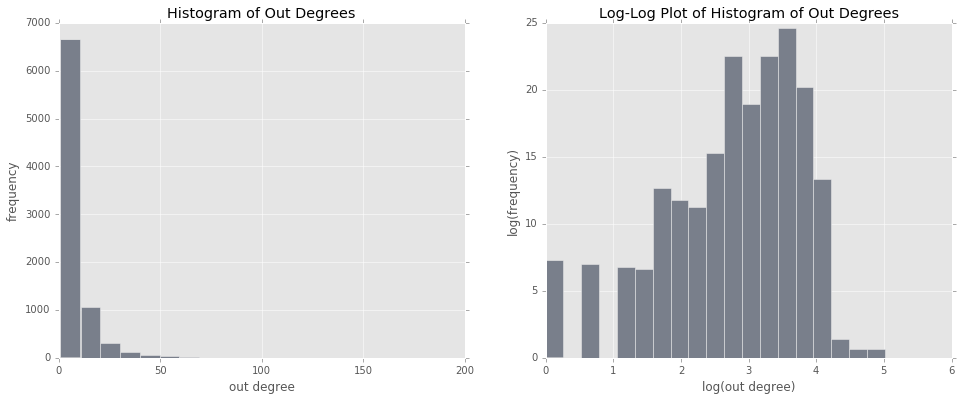

In [35]:
eda_plot('synNet.eda')

While the regular plot somewhat resembles a power law, the log-log plot does not show a straight downward linear trend. So the distribution resembles a power law, but it does not strictly follow it.

# HW 7.2: Shortest path graph distances (NLTK synonyms)

> Write (reuse your code from 7.0) an MRJob class to find shortest path graph distances, 
and apply it to the NLTK synonyms network dataset.

In [28]:
input_file = 'synNet.txt'
output_folder = 'synNet.shortest_path'

!rm -rf output/$output_folder
!hdfs dfs -rm -r -f -skipTrash $hdfs_base_folder/output/$output_folder

%time !python ShortestPathGraphDistanceDriver.py \
    --runner-type hadoop \
    --mapper-count $mapper_count \
    --reducer-count $reducer_count \
    --hdfs-base-folder $hdfs_base_folder \
    --input-file input/$input_file \
    --output-folder output/$output_folder \
    --batch-size 1 \
    --source-node 7827 \
    --target-node 536

Deleted /user/ubuntu/output/synNet.shortest_path
2016-03-09 11:39:12.002205 Running iteration 1
2016-03-09 11:40:02.066947 Running iteration 2
2016-03-09 11:40:47.317694 Running iteration 3
7827 -> 536 = 3 (7827, 1426, 3553, 536)
Completed in 3 iterations
CPU times: user 2.4 s, sys: 284 ms, total: 2.68 s
Wall time: 2min 25s


# HW 7.3: Exploratory data analysis (Wikipedia)

> Using MRJob, explore the Wikipedia network data on the AWS cloud. Reuse your code from HW 7.1---does is scale well? 

> Be cautioned that Wikipedia is a directed network, where links are not symmetric. 
So, even though a node may be linked to, it will not appear as a primary record itself if it has no out-links. 
This means that you may have to ADJUST your code (depending on its design).

## Run Wikipedia EDA with a Hadoop runner

In [79]:
input_file = 'all-pages-indexed-out.txt'
output_folder = 'wikipedia.eda'

!rm -rf output/$output_folder
!hdfs dfs -rm -r -f -skipTrash output/$output_folder

%time !python DegreeDistributionJob.py \
    -r hadoop \
    --strict-protocols \
    --no-output \
    --no-bootstrap-mrjob \
    --output-dir=hdfs://$hdfs_base_folder/output/$output_folder \
    hdfs://$hdfs_base_folder/input/$input_file \
    2> /dev/null

CPU times: user 1.77 s, sys: 200 ms, total: 1.97 s
Wall time: 2min 9s


## Plot a histogram of the Wikipedia EDA

total edges = 142114057
average edges = 24.5817208616


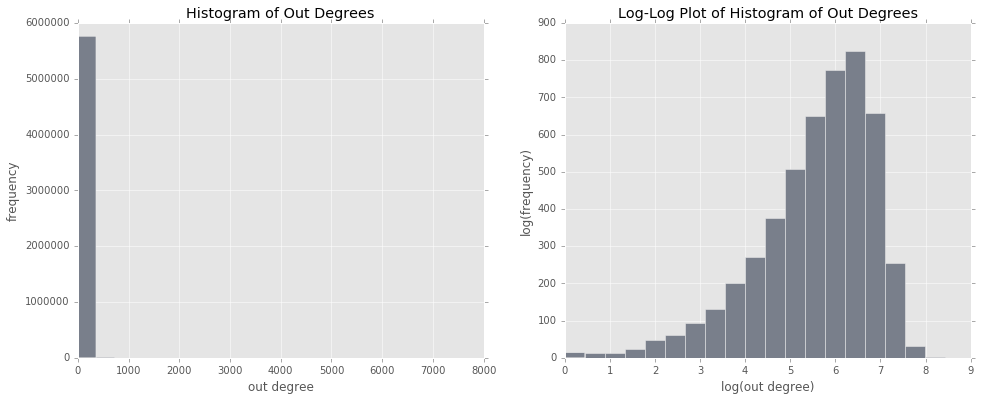

In [36]:
eda_plot('wikipedia.eda')

While there is a large number of elements at the lower range, when we break the lower range into smaller divisions via a log scale, it does not follow a power-law trend.

# HW 7.4: Shortest path graph distances (Wikipedia)

> Using MRJob, find shortest path graph distances in the Wikipedia network on the AWS cloud.
Reuse your code from 7.2, but once again be warned of Wikipedia being a directed network.
When running your code on the Wikipedia network, proof its function by running the job:

> - shortest path from "Ireland" (index=6176135) to "University of California, Berkeley" (index=13466359)

> and show your code's output.

In [37]:
input_file = 'all-pages-indexed-out.txt'
output_folder = 'wikipedia.shortest_path'

!rm -rf output/$output_folder
!hdfs dfs -rm -r -f -skipTrash $hdfs_base_folder/output/$output_folder

%time !python ShortestPathGraphDistanceDriver.py \
    --runner-type hadoop \
    --mapper-count $mapper_count \
    --reducer-count $reducer_count \
    --hdfs-base-folder $hdfs_base_folder \
    --input-file input/$input_file \
    --output-folder output/$output_folder \
    --batch-size 1 \
    --source-node 6176135 \
    --target-node 13466359

Deleted /user/ubuntu/output/wikipedia.shortest_path
2016-03-09 11:50:54.615908 Running iteration 1
2016-03-09 11:56:16.551152 Running iteration 2
6176135 -> 13466359 = 2 (6176135, 11607791, 13466359)
Completed in 2 iterations
CPU times: user 11.2 s, sys: 1.21 s, total: 12.4 s
Wall time: 12min 31s


# HW 7.5: Conceptual exercise: Largest single-source network distances

> Suppose you wanted to find the largest network distance from a single source,
i.e., a node that is the furthest (but still reachable) from a single source.
> As you respond, please comment on program structure, runtimes, iterations, general system requirements, etc...

## HW 7.5a

> How would you implement this task? How is this different from finding the shortest path graph distances?

There are multiple ways to define a node as being the furthest away from a single source node. In one interpretation, we identify the node which has the longest possible simple path from the source node (the [longest path problem](https://en.wikipedia.org/wiki/Longest_path_problem)). In another interpretation, we identify all shortest paths to every node from the source node and from there identify the node that maximizes that shortest path (the [all-pairs shortest path problem](https://en.wikipedia.org/wiki/Shortest_path_problem#All-pairs_shortest_paths)).

Since the follow-up question specifically asks for how it differs from shortest path, we can assume the former interpretation.

As a naive implementation, I would perform the breadth-first search, and at each MapReduce iteration $i$, I would emit all simple paths (paths without cycles) of length $i$, thus pruning paths that result in cycles. However, since there are $2^n$ possible paths, this would ultimately grow exponentially at each iteration, assuming there were many simple paths and few cycles.

## HW 7.5c

> Is this task more difficult to implement than the shortest path distance?

Due to the nature of the problem (you have to retain all paths that are of length $k$ in order to identify if there are any paths of length $k+1$, this is ultimately much more time-consuming than the shortest path distance problem. However, it is not more difficult to implement.